In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
# Question 2: Neural Ordinary Differential Equations (Neural ODEs)
# File: neural_ode_classification.py

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

# Install torchdiffeq: pip install torchdiffeq
try:
    from torchdiffeq import odeint
except ImportError:
    print("Please install torchdiffeq: pip install torchdiffeq")
    raise

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class StandardNN(nn.Module):
    """Standard fully connected neural network with one hidden layer"""
    
    def __init__(self, input_dim, hidden_dim=32, output_dim=2):
        super(StandardNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.layers(x)

class ODEFunc(nn.Module):
    """ODE function f(h, t) for Neural ODE"""
    
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Initialize with small weights for stability
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
    
    def forward(self, t, h):
        # t is time (scalar), h is hidden state
        # ODE function should return dh/dt
        return self.net(h)

class NeuralODE(nn.Module):
    """Neural ODE model for classification"""
    
    def __init__(self, input_dim, hidden_dim=32, output_dim=2):
        super(NeuralODE, self).__init__()
        
        # Initial transformation layer
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        
        # ODE function
        self.ode_func = ODEFunc(hidden_dim)
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        # Integration time
        self.integration_time = torch.tensor([0., 1.])
    
    def forward(self, x):
        # Initial hidden state
        h0 = self.input_layer(x)
        
        # Solve ODE
        # odeint expects (time_points, initial_state, ode_function)
        h_trajectory = odeint(self.ode_func, h0, self.integration_time, method='dopri5')
        
        # Take the final state (at t=1)
        h_final = h_trajectory[-1]  # Shape: [batch_size, hidden_dim]
        
        # Output classification
        return self.output_layer(h_final)

def create_dataset(dataset_type='moons', n_samples=1000):
    """Create dataset for classification"""
    
    if dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=0.3, random_state=42)
        title = "Moons Dataset"
    elif dataset_type == 'circles':
        X, y = make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=42)
        title = "Circles Dataset"
    elif dataset_type == 'blobs':
        X, y = make_blobs(n_samples=n_samples, centers=2, n_features=2, 
                         random_state=42, cluster_std=1.5)
        title = "Blobs Dataset"
    elif dataset_type == 'mnist':
        # Load MNIST digits 0 and 1, downsample to 8x8
        digits = load_digits()
        # Select only digits 0 and 1
        mask = (digits.target == 0) | (digits.target == 1)
        X = digits.data[mask] / 16.0  # Normalize to [0,1]
        y = digits.target[mask]
        title = "MNIST Binary (0 vs 1)"
    else:
        raise ValueError("Dataset type not supported")
    
    return X, y, title

def train_model(model, X_train, y_train, X_val, y_val, epochs=200, lr=0.01, verbose=True):
    """Train the model and return training history"""
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)
    
    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
    
    # Training history
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Calculate training accuracy
        with torch.no_grad():
            _, predicted = torch.max(outputs.data, 1)
            train_acc = (predicted == y_train_tensor).float().mean().item()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_acc = (val_predicted == y_val_tensor).float().mean().item()
        
        # Store history
        train_losses.append(loss.item())
        train_accuracies.append(train_acc)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_acc)
        
        if verbose and epoch % 20 == 0:
            print(f'Epoch {epoch:3d}: Train Loss: {loss.item():.4f}, '
                  f'Train Acc: {train_acc:.4f}, Val Loss: {val_loss.item():.4f}, '
                  f'Val Acc: {val_acc:.4f}')
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

def plot_decision_boundary(model, X, y, title, ax=None):
    """Plot decision boundary for 2D data"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create a mesh
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Make predictions on the mesh
    model.eval()
    with torch.no_grad():
        mesh_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
        predictions = model(mesh_points)
        _, predicted_classes = torch.max(predictions, 1)
        Z = predicted_classes.numpy().reshape(xx.shape)
    
    # Plot
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    ax.set_title(title)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    
    return ax

def compare_models(X, y, dataset_title):
    """Compare Standard NN vs Neural ODE"""
    
    print(f"\n{'='*60}")
    print(f"Dataset: {dataset_title}")
    print(f"{'='*60}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Further split training into train/validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    input_dim = X_train.shape[1]
    hidden_dim = 32 if input_dim <= 2 else 64
    
    print(f"Input dimension: {input_dim}")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")
    
    # Part A: Standard Neural Network
    print(f"\nPart A: Training Standard Neural Network...")
    standard_model = StandardNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=2)
    standard_history = train_model(standard_model, X_train, y_train, X_val, y_val, 
                                 epochs=200, lr=0.01, verbose=False)
    
    # Part B: Neural ODE
    print(f"Part B: Training Neural ODE...")
    neural_ode_model = NeuralODE(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=2)
    ode_history = train_model(neural_ode_model, X_train, y_train, X_val, y_val, 
                            epochs=200, lr=0.01, verbose=False)
    
    # Evaluate on test set
    standard_model.eval()
    neural_ode_model.eval()
    
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test)
        
        # Standard NN predictions
        standard_outputs = standard_model(X_test_tensor)
        _, standard_pred = torch.max(standard_outputs, 1)
        standard_accuracy = accuracy_score(y_test, standard_pred.numpy())
        
        # Neural ODE predictions
        ode_outputs = neural_ode_model(X_test_tensor)
        _, ode_pred = torch.max(ode_outputs, 1)
        ode_accuracy = accuracy_score(y_test, ode_pred.numpy())
    
    # Part C: Results and Analysis
    print(f"\nPart C: Results and Analysis")
    print(f"Standard NN Test Accuracy: {standard_accuracy:.4f}")
    print(f"Neural ODE Test Accuracy: {ode_accuracy:.4f}")
    
    # Model complexity analysis
    standard_params = sum(p.numel() for p in standard_model.parameters())
    ode_params = sum(p.numel() for p in neural_ode_model.parameters())
    print(f"Standard NN Parameters: {standard_params}")
    print(f"Neural ODE Parameters: {ode_params}")
    
    # Plot results
    if input_dim == 2:  # Only plot decision boundaries for 2D data
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Decision boundaries
        plot_decision_boundary(standard_model, X_test, y_test, 
                             f'Standard NN - {dataset_title}', axes[0, 0])
        plot_decision_boundary(neural_ode_model, X_test, y_test, 
                             f'Neural ODE - {dataset_title}', axes[0, 1])
        
        # Training curves
        axes[1, 0].plot(standard_history['train_losses'], label='Standard NN Train')
        axes[1, 0].plot(standard_history['val_losses'], label='Standard NN Val')
        axes[1, 0].plot(ode_history['train_losses'], label='Neural ODE Train')
        axes[1, 0].plot(ode_history['val_losses'], label='Neural ODE Val')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].set_title('Training Loss')
        axes[1, 0].legend()
        axes[1, 0].set_yscale('log')
        
        axes[1, 1].plot(standard_history['train_accuracies'], label='Standard NN Train')
        axes[1, 1].plot(standard_history['val_accuracies'], label='Standard NN Val')
        axes[1, 1].plot(ode_history['train_accuracies'], label='Neural ODE Train')
        axes[1, 1].plot(ode_history['val_accuracies'], label='Neural ODE Val')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].set_title('Training Accuracy')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.savefig(f'neural_ode_{dataset_title.lower().replace(" ", "_")}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    else:  # For high-dimensional data, just plot training curves
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        axes[0].plot(standard_history['train_losses'], label='Standard NN Train')
        axes[0].plot(standard_history['val_losses'], label='Standard NN Val')
        axes[0].plot(ode_history['train_losses'], label='Neural ODE Train')
        axes[0].plot(ode_history['val_losses'], label='Neural ODE Val')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title(f'Training Loss - {dataset_title}')
        axes[0].legend()
        axes[0].set_yscale('log')
        
        axes[1].plot(standard_history['train_accuracies'], label='Standard NN Train')
        axes[1].plot(standard_history['val_accuracies'], label='Standard NN Val')
        axes[1].plot(ode_history['train_accuracies'], label='Neural ODE Train')
        axes[1].plot(ode_history['val_accuracies'], label='Neural ODE Val')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title(f'Training Accuracy - {dataset_title}')
        axes[1].legend()
        
        plt.tight_layout()
        plt.savefig(f'neural_ode_{dataset_title.lower().replace(" ", "_")}.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    # Print detailed classification report
    print(f"\nDetailed Classification Report - Standard NN:")
    print(classification_report(y_test, standard_pred.numpy(), target_names=['Class 0', 'Class 1']))
    
    print(f"\nDetailed Classification Report - Neural ODE:")
    print(classification_report(y_test, ode_pred.numpy(), target_names=['Class 0', 'Class 1']))
    
    return {
        'standard_accuracy': standard_accuracy,
        'ode_accuracy': ode_accuracy,
        'standard_params': standard_params,
        'ode_params': ode_params,
        'standard_history': standard_history,
        'ode_history': ode_history
    }

def analyze_ode_trajectory(model, X_sample):
    """Analyze the ODE trajectory for a sample"""
    
    model.eval()
    with torch.no_grad():
        # Get initial hidden state
        h0 = model.input_layer(X_sample)
        
        # Create time points for visualization
        t_eval = torch.linspace(0, 1, 21)  # 21 time points from 0 to 1
        
        # Solve ODE with intermediate time points
        trajectory = odeint(model.ode_func, h0, t_eval, method='dopri5')
        
        return t_eval.numpy(), trajectory.numpy()


Neural ODE Classification Experiment

Dataset: Moons Dataset
Input dimension: 2
Training samples: 640
Validation samples: 160
Test samples: 200

Part A: Training Standard Neural Network...
Part B: Training Neural ODE...

Part C: Results and Analysis
Standard NN Test Accuracy: 0.9500
Neural ODE Test Accuracy: 0.9200
Standard NN Parameters: 162
Neural ODE Parameters: 3330


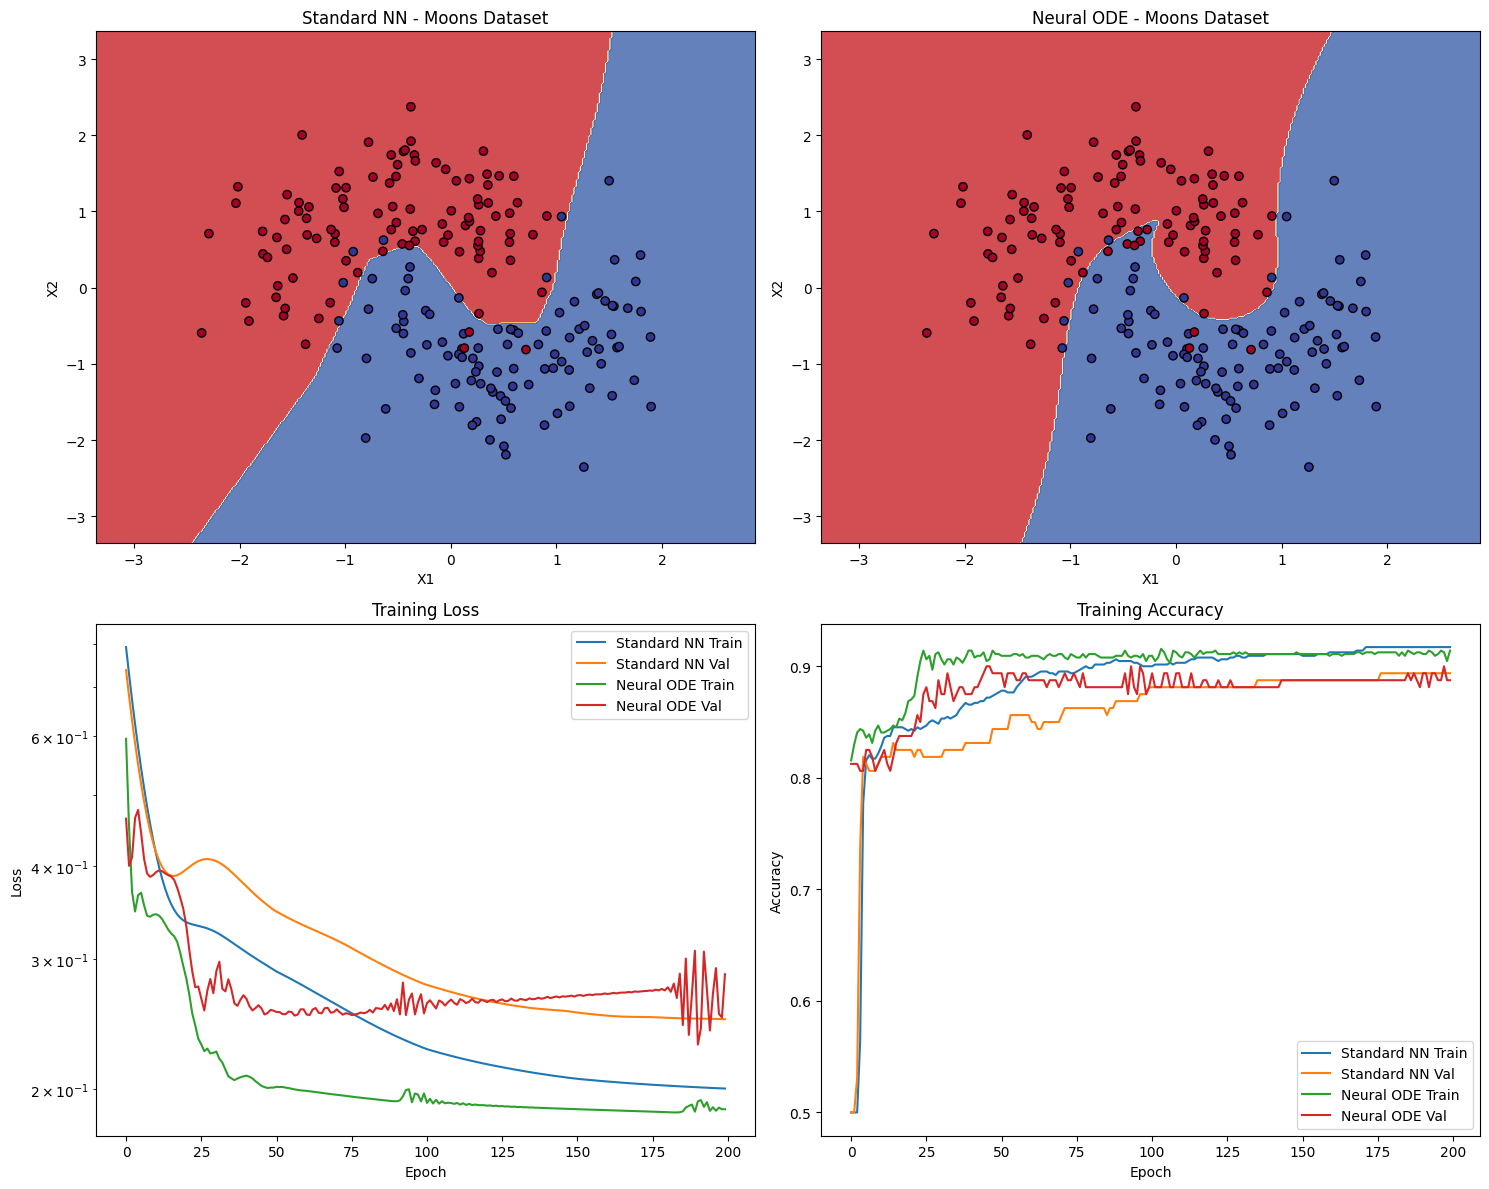


Detailed Classification Report - Standard NN:
              precision    recall  f1-score   support

     Class 0       0.93      0.97      0.95       100
     Class 1       0.97      0.93      0.95       100

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200


Detailed Classification Report - Neural ODE:
              precision    recall  f1-score   support

     Class 0       0.93      0.91      0.92       100
     Class 1       0.91      0.93      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200


Dataset: Circles Dataset
Input dimension: 2
Training samples: 640
Validation samples: 160
Test samples: 200

Part A: Training Standard Neural Network...
Part B: Training Neural ODE...

Part C: Results and Analysis
Standard NN Test Accuracy: 0.9000
Neur

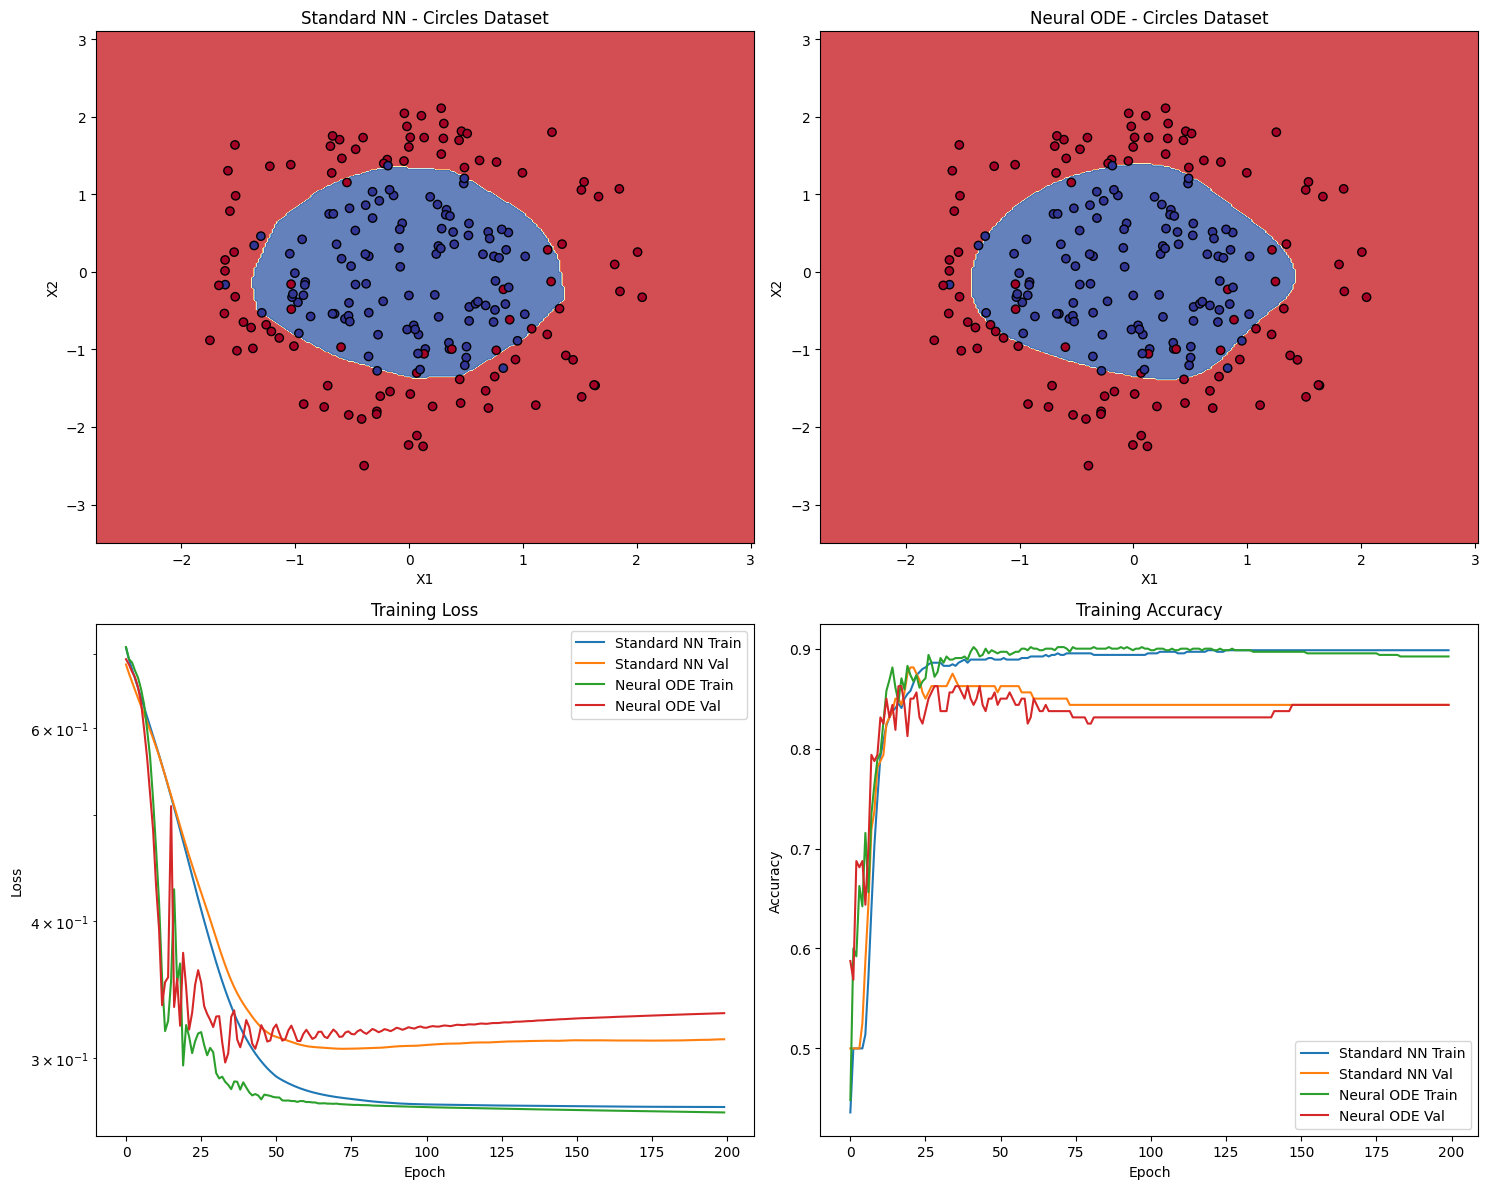


Detailed Classification Report - Standard NN:
              precision    recall  f1-score   support

     Class 0       0.93      0.87      0.90       100
     Class 1       0.88      0.93      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200


Detailed Classification Report - Neural ODE:
              precision    recall  f1-score   support

     Class 0       0.93      0.88      0.90       100
     Class 1       0.89      0.93      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200


Dataset: Blobs Dataset
Input dimension: 2
Training samples: 640
Validation samples: 160
Test samples: 200

Part A: Training Standard Neural Network...
Part B: Training Neural ODE...

Part C: Results and Analysis
Standard NN Test Accuracy: 1.0000
Neural

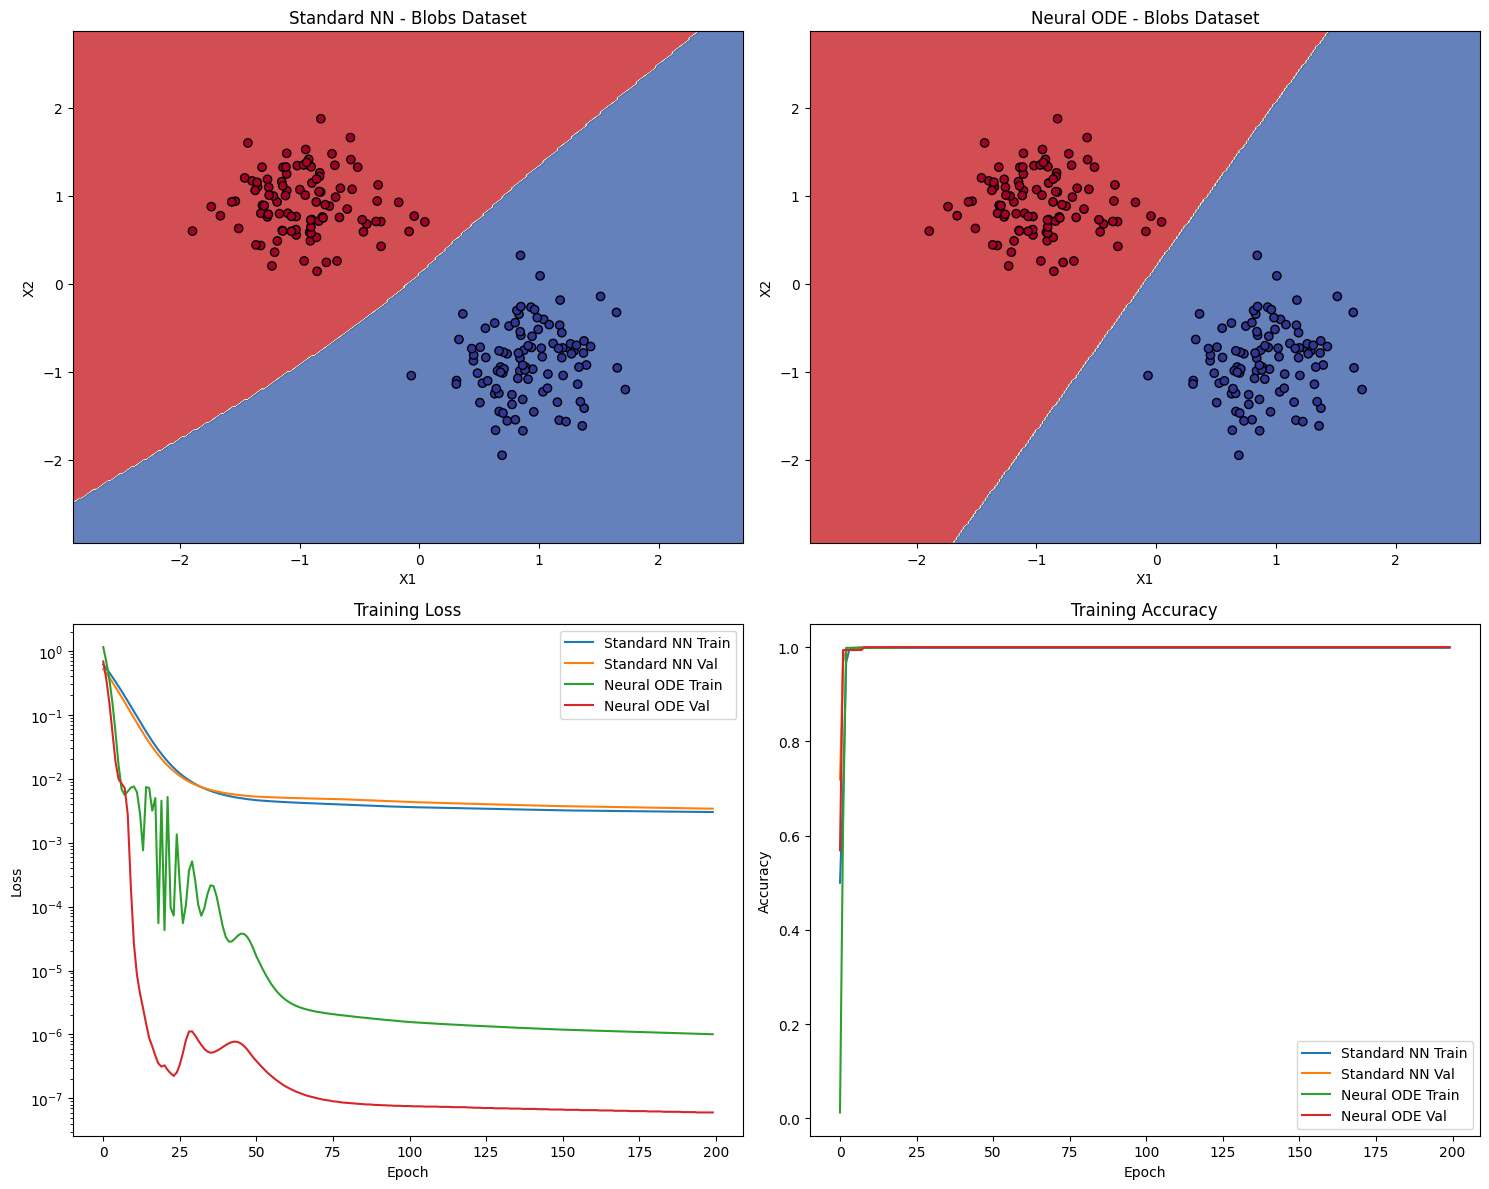


Detailed Classification Report - Standard NN:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       100
     Class 1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Detailed Classification Report - Neural ODE:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       100
     Class 1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Dataset: MNIST Binary (0 vs 1)
Input dimension: 64
Training samples: 230
Validation samples: 58
Test samples: 72

Part A: Training Standard Neural Network...
Part B: Training Neural ODE...

Part C: Results and Analysis
Standard NN Test Accuracy: 1.0000

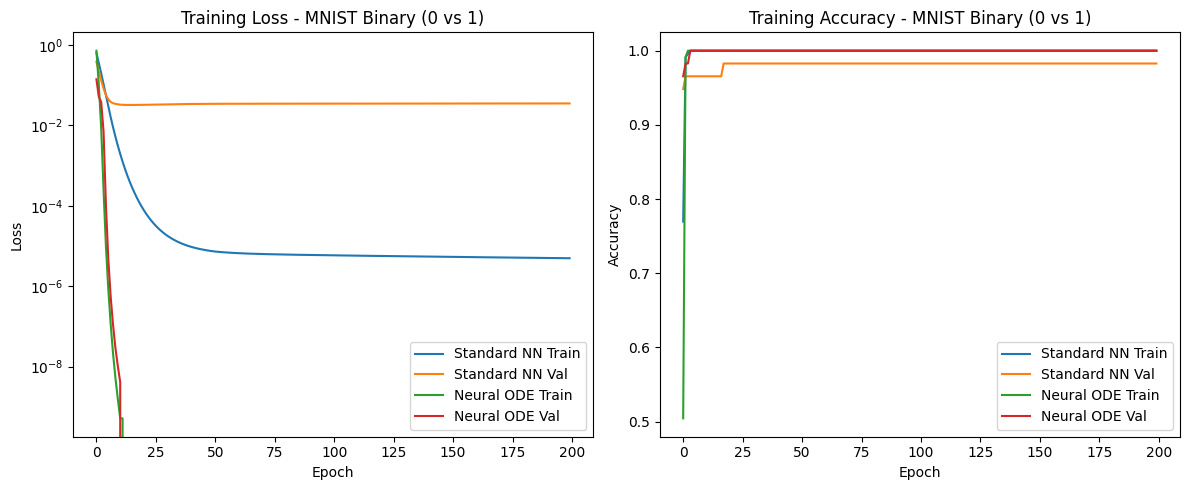


Detailed Classification Report - Standard NN:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        36
     Class 1       1.00      1.00      1.00        36

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72


Detailed Classification Report - Neural ODE:
              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.99        36
     Class 1       1.00      0.97      0.99        36

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72


SUMMARY COMPARISON

Dataset: MOONS
Standard NN Accuracy: 0.9500
Neural ODE Accuracy:  0.9200
Accuracy Difference:  -0.0300
Standard NN Params:   162
Neural ODE Params:    3330
Parameter Ratio:      20.56x

Dataset: CIRCLES
Standard NN Accuracy: 0.9000


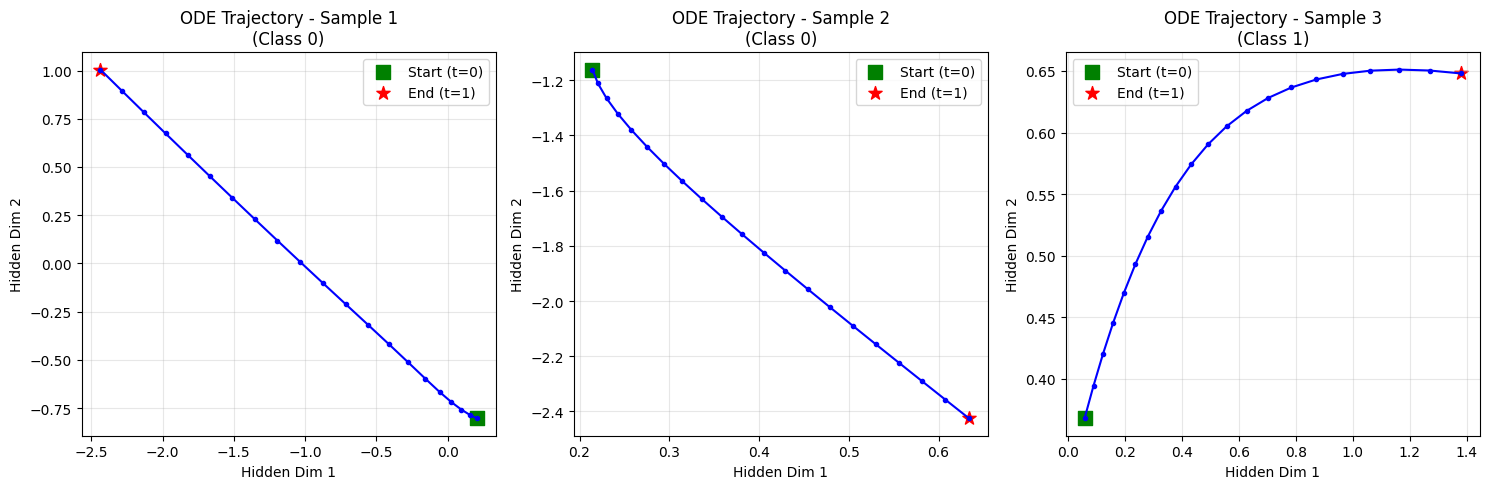

In [7]:
def main():
    """Main function to run experiments"""
    
    print("Neural ODE Classification Experiment")
    print("=" * 60)
    
    # Test on different datasets
    datasets = ['moons', 'circles', 'blobs', 'mnist']
    results = {}
    
    for dataset_type in datasets:
        try:
            # Create dataset
            X, y, title = create_dataset(dataset_type, n_samples=1000)
            
            # Compare models
            result = compare_models(X, y, title)
            results[dataset_type] = result
            
        except Exception as e:
            print(f"Error processing {dataset_type}: {e}")
            continue
    
    # Summary comparison
    print(f"\n{'='*60}")
    print("SUMMARY COMPARISON")
    print(f"{'='*60}")
    
    for dataset_type, result in results.items():
        print(f"\nDataset: {dataset_type.upper()}")
        print(f"Standard NN Accuracy: {result['standard_accuracy']:.4f}")
        print(f"Neural ODE Accuracy:  {result['ode_accuracy']:.4f}")
        print(f"Accuracy Difference:  {result['ode_accuracy'] - result['standard_accuracy']:.4f}")
        print(f"Standard NN Params:   {result['standard_params']}")
        print(f"Neural ODE Params:    {result['ode_params']}")
        print(f"Parameter Ratio:      {result['ode_params']/result['standard_params']:.2f}x")
    
    # Additional analysis: ODE trajectory visualization for 2D data
    if 'moons' in results:
        print(f"\nODE Trajectory Analysis (Moons Dataset)")
        print("-" * 40)
        
        # Recreate moons dataset for trajectory analysis
        X, y, _ = create_dataset('moons', n_samples=100)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Retrain a simple ODE model for trajectory analysis
        ode_model = NeuralODE(input_dim=2, hidden_dim=16, output_dim=2)
        train_model(ode_model, X_train_scaled, y_train, X_train_scaled, y_train, 
                   epochs=100, lr=0.01, verbose=False)
        
        # Analyze trajectory for a few test samples
        sample_indices = [0, 1, 2]
        
        fig, axes = plt.subplots(1, len(sample_indices), figsize=(15, 5))
        
        for i, idx in enumerate(sample_indices):
            sample = torch.FloatTensor(X_test_scaled[idx:idx+1])
            t_points, trajectory = analyze_ode_trajectory(ode_model, sample)
            
            # Plot trajectory in hidden space (first 2 dimensions)
            axes[i].plot(trajectory[:, 0, 0], trajectory[:, 0, 1], 'b-o', markersize=3)
            axes[i].set_title(f'ODE Trajectory - Sample {idx+1}\n(Class {y_test[idx]})')
            axes[i].set_xlabel('Hidden Dim 1')
            axes[i].set_ylabel('Hidden Dim 2')
            axes[i].grid(True, alpha=0.3)
            
            # Mark start and end points
            axes[i].scatter(trajectory[0, 0, 0], trajectory[0, 0, 1], 
                          c='green', s=100, marker='s', label='Start (t=0)')
            axes[i].scatter(trajectory[-1, 0, 0], trajectory[-1, 0, 1], 
                          c='red', s=100, marker='*', label='End (t=1)')
            axes[i].legend()
        
        plt.tight_layout()
        plt.savefig('neural_ode_trajectories.png', dpi=300, bbox_inches='tight')
        plt.show()

if __name__ == "__main__":
    main()